<a href="https://colab.research.google.com/github/pedrohortencio/cancer-detection/blob/main/BreakHis/breakhis_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Pedro Hortêncio M.R.
>
> Universidade Federal de Goiás

# Rede Neural Convolucional e Data Augmentation para Classificação de Tumores em Tecido Mamário

[Breast Cancer Histopathological Database - UFPR](https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/)

## Importação de Bibliotecas

In [ ]:
from google.colab import drive
import os, sys, shutil

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from glob import glob

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Concatenate, Flatten, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, ReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD

from sklearn.utils import shuffle

sns.set_theme()

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pyfastcopy
import pyfastcopy       # Biblioteca que otimiza a execução do shutil.copy()

  Created wheel for pyfastcopy: filename=pyfastcopy-1.0.3-cp37-none-any.whl size=3770 sha256=1cb00c8e13b93ccd8999c25843f49a6d662a30f40909f372488cdd926b67db48
  Stored in directory: /root/.cache/pip/wheels/43/ef/5b/424484e3955a0ac0e364fbf2648aaaab4be135b69a8b2b216d
Successfully built pyfastcopy


## Verificação das Imagens

In [ ]:
print("Quantidade de Amostras Benignas:",
      len(os.listdir('/content/drive/MyDrive/data_400X/SOB/400X/benign')))

print("Quantidade de Amostras Malignas:",
      len(os.listdir('/content/drive/MyDrive/data_400X/SOB/400X/malignant')))

Quantidade de Amostras Benignas: 588
Quantidade de Amostras Malignas: 1232


In [ ]:
caminho_base = "/content/drive/MyDrive/data_400X/SOB/400X"      # Localização das imagens

In [ ]:
# Lista com caminho de todas as imagens que contenham amostras benignas e malignas
lista_imgs_b = glob(r"/content/drive/MyDrive/data_400X/SOB/400X/benign/*.png")
lista_imgs_m = glob(r"/content/drive/MyDrive/data_400X/SOB/400X/malignant/*.png")

# Redistribuindo aleatoriamente as imagens
lista_imgs_b = shuffle(lista_imgs_b, random_state = 42)
lista_imgs_m = shuffle(lista_imgs_m, random_state=42)

In [ ]:
lista_imgs_b[:2]

['/content/drive/MyDrive/data_400X/SOB/400X/benign/SOB_B_TA-14-16184CD-400-022.png',
 '/content/drive/MyDrive/data_400X/SOB/400X/benign/SOB_B_F-14-23060CD-400-015.png']

In [ ]:
lista_imgs_m[:2]

['/content/drive/MyDrive/data_400X/SOB/400X/malignant/SOB_M_DC-14-9461-400-025.png',
 '/content/drive/MyDrive/data_400X/SOB/400X/malignant/SOB_M_DC-14-12312-400-024.png']

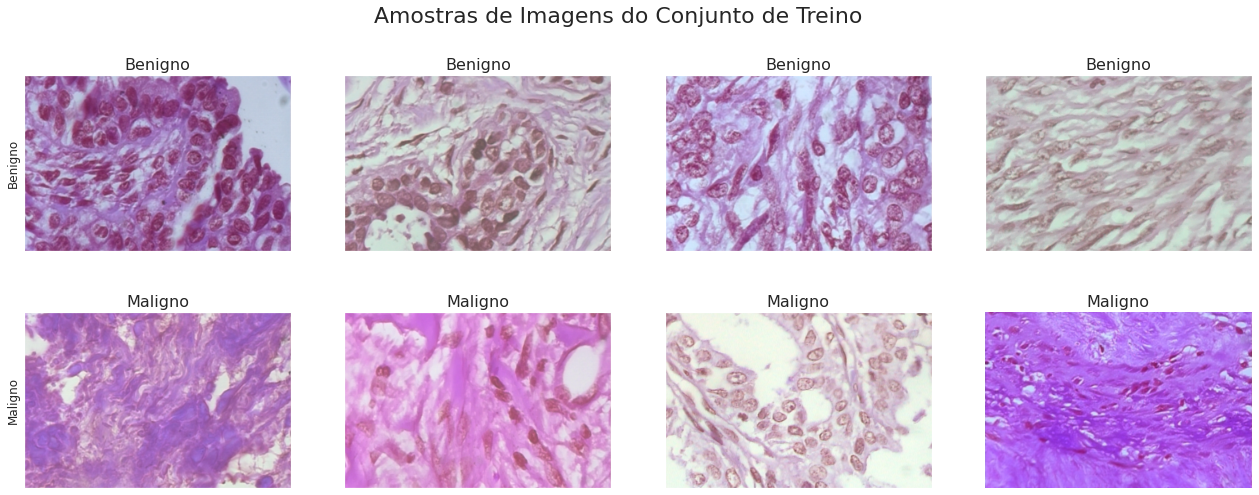

In [ ]:
#@title Amostra de Imagens
#@markdown _Duplo clique para abrir o código._

figure_cols = 4

categories = ["Benigno", "Maligno"]

# Cria a figura
f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                      figsize=(22,8))

# Loop sobre o index criado anteriormente
for i, cat in enumerate(categories):
    # Seleciona aleatoriamente (figure_cols) imagens
    if cat == "Benigno":
        sample = shuffle(lista_imgs_b)
    else:
        sample = shuffle(lista_imgs_m)

    # Loop que preenche os subplots com as imagens elecionadas
    for j in range(0,figure_cols):
        file = sample[j]    
        im=cv2.imread(file)                                 # Lê a imagem
        ax[i, j].imshow(im, resample=True, cmap='gray')     # Plota a imagem
        ax[i, j].set_title(cat, fontsize=16)                # Cria um título
        ax[i, j].grid(False)                                # Desabilita o grid
        plt.box(False)                              # Desabilita a caixa do gráfico
        ax[i, j].set_xticks([])                     # Desabilita os números no eixo x
        ax[i, j].set_yticks([])                     # Desabilita os números no eixo y



ax[0,0].set_ylabel('Benigno', size='large')
ax[1,0].set_ylabel('Maligno', size='large')


f.suptitle("Amostras de Imagens do Conjunto de Treino",
           size=22, y=0.98)

# Salva a imagem
plt.savefig("Amostra-Imagens.png",
            bbox_inches='tight', dpi=100)

# Realiza o plot
plt.show()

## Copiando Imagens para o Google Colab

As imagens serão copiadas do drive (montado) para o disco local do Colab, para facilitar a alimentação do modelo. Será criada uma estrutura específica de subdiretórios para viabilizar o uso do ImageDataGenerator, do Keras.

In [ ]:
# Criando uma nova pasta/diretório
dir_base = 'dir_base'
os.mkdir(dir_base)

# Dentro da pasta "dir_base", haverá a seguinte estrutura:

# dir_treino
    # a_benigno
    # b_maligno

# dir_teste
    # a_benigno
    # b_maligno


# Criando a pasta "dir_treino"
dir_treino = os.path.join(dir_base, 'dir_treino')
os.mkdir(dir_treino)

# Criando a pasta "dir_teste"
dir_teste = os.path.join(dir_base, 'dir_teste')
os.mkdir(dir_teste)


# Criando as pastas que ficarão dentro das pastas "dir_treino" e "dir_teste"
# Dentro dessas pastas estarão as imagens correspondentes a cada um dos labels

# Crindo pastas dentro de "dir_treino"
benigno = os.path.join(dir_treino, 'a_benigno')
os.mkdir(benigno)
maligno = os.path.join(dir_treino, 'b_maligno')
os.mkdir(maligno)

# Criando pastas dentro de "dir_teste"
benigno = os.path.join(dir_teste, 'a_benigno')
os.mkdir(benigno)
maligno = os.path.join(dir_teste, 'b_maligno')
os.mkdir(maligno)

In [ ]:
# Checando as pastas no diretório base
os.listdir('dir_base')

['dir_treino', 'dir_teste']

In [ ]:
# Checando as pastas no diretório de treino
os.listdir('dir_base/dir_treino')

['a_benigno', 'b_maligno']

In [ ]:
# Checando as pastas no diretório de teste
os.listdir('dir_base/dir_teste')

['a_benigno', 'b_maligno']

In [ ]:
# Divisão das amostras em 25% Validação e 75% Treino

num_amostras_b = int(np.ceil(len(lista_imgs_b)*0.25))       # 147
num_amostras_m = int(np.ceil(len(lista_imgs_m)*0.25))       # 308

# Mudando as imagens de pasta
for count, image in enumerate(lista_imgs_b):
    
    # Da imagem 0 - 146 (147 amostras): salvar na pasta /content/dir_base/dir_teste/a_benigno
    # Da imagem 147 - 588 (441 amostras): salvar na pasta /content/dir_base/dir_treino/a_benigno
    
    if count < num_amostras_b:
        dir = '/content/dir_base/dir_teste/a_benigno'
    else:
        dir = '/content/dir_base/dir_treino/a_benigno'


    src = image                                         # Define o caminho de origem
    dst = os.path.join(dir, image.split('/')[-1])       # Define o caminho de destino
    
    shutil.copyfile(src, dst)                   # Copia a imagem de uma pasta para outra


# Mesmo processo, mas para as imagens de Teste

for count, image in enumerate(lista_imgs_m):
    
    # Da imagem 0 - 307 (308 amostras): salvar na pasta /content/dir_base/dir_teste/b_maligno
    # Da imagem 308 - 1232 (924 amostras): salvar na pasta /content/dir_base/dir_treino/b_maligno
    
    if count < num_amostras_m:
        dir = '/content/dir_base/dir_teste/b_maligno'
    else:
        dir = '/content/dir_base/dir_treino/b_maligno'


    src = image                                         # Define o caminho de origem
    dst = os.path.join(dir, image.split('/')[-1])       # Define o caminho de destino
    
    shutil.copyfile(src, dst)                   # Copia a imagem de uma pasta para outra

In [ ]:
print("Quantidade de Amostras Benignas de Treino:",
      len(os.listdir('/content/dir_base/dir_treino/a_benigno')))

print("Quantidade de Amostras Benignas de Teste:",
      len(os.listdir('/content/dir_base/dir_teste/a_benigno')))

print("Quantidade de Amostras Malignas de Treino:",
      len(os.listdir('/content/dir_base/dir_treino/b_maligno')))

print("Quantidade de Amostras Malignas de Teste:",
      len(os.listdir('/content/dir_base/dir_teste/b_maligno')))

Quantidade de Amostras Benignas de Treino: 441
Quantidade de Amostras Benignas de Teste: 147
Quantidade de Amostras Malignas de Treino: 924
Quantidade de Amostras Malignas de Teste: 308


## Criação do ImageDataGenerator

In [ ]:
BATCH_SIZE = 50
TAMANHO_IMAGEM = 96
train_path = '/content/dir_base/dir_treino'     # Caminho das imagens de treino
test_path = '/content/dir_base/dir_teste'       # Caminho das imagens de teste

num_amostras_treino = len(os.listdir('/content/dir_base/dir_treino/a_benigno')) + len(os.listdir('/content/dir_base/dir_teste/a_benigno'))   

### Teste de Data Augmentation

In [ ]:
datagen_exemplo = ImageDataGenerator(brightness_range=[.95,1.05],   # Variação de brilho
                                     channel_shift_range=20,        # Variação de cor
                                     zoom_range=[0.95,0.95],        # Variação de zoom
                                     horizontal_flip=True,          # Espelhamento horizontal
                                     vertical_flip=True)            # Espelhamento vertical

Found 1365 images belonging to 2 classes.


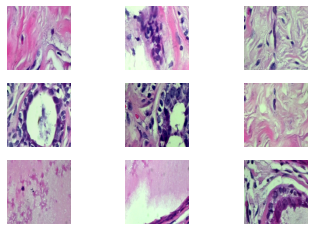

In [ ]:
it = datagen_exemplo.flow_from_directory(
            train_path, shuffle=False, batch_size=1)
# Gera uma amostra e plot
for i in range(9):
    # Cria Subplot
    plt.subplot(330 + 1 + i)
    # Gera as imagens
    batch = it.next()
    # Converte as imagens para uint8 para visualização
    image = batch[0].astype('uint8')
    # Plot da imagem
    plt.grid(False)
    plt.box(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image[0])

# Mostrando o subplot
plt.show()

### Criação dos Generators

In [ ]:
# Data generador de treino com as mesmas especificações anteriores
datagen_treino = ImageDataGenerator(rescale=1.0/255,
                             brightness_range=[.95,1.05],
                             channel_shift_range=30,
                             zoom_range=[0.95,1.05],
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.2)

# Data generator de validação apenas com o espelhamento
datagen_val = ImageDataGenerator(rescale=1.0/255,
                                 horizontal_flip=True,
                                vertical_flip=True,
                                 validation_split=0.2)

# Data generator de teste sem nenhum tipo de manipulação
datagen_teste = ImageDataGenerator(rescale=1.0/255)

In [ ]:
# Cria o gerador de treino
gen_treino = datagen_treino.flow_from_directory(
            train_path,                                 # Caminho
            target_size=(TAMANHO_IMAGEM, TAMANHO_IMAGEM),   # Tamanho da imagem
            batch_size=BATCH_SIZE,
            subset="training",                          # Divisão em treino e validação
            seed=42,                                # Garante consistência na randomização das amostras
            class_mode='categorical',               # Modo de classificação
)

# Cria o gerador de validação
gen_val = datagen_val.flow_from_directory(
            train_path,
            target_size=(TAMANHO_IMAGEM, TAMANHO_IMAGEM),
            batch_size=BATCH_SIZE,
            subset="validation",
            seed=42,
            class_mode='categorical',
)

# Cria o gerador de teste
test_gen = datagen_teste.flow_from_directory(
            test_path,
            target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),
            batch_size=1,                               # Teste será feito imagem a imagem
            class_mode=None,   
            shuffle=False)   

Found 1093 images belonging to 2 classes.
Found 272 images belonging to 2 classes.
Found 455 images belonging to 2 classes.


In [ ]:
# Define a quantidade de passos por época
STEP_SIZE_TREINO = gen_treino.n // gen_treino.batch_size
STEP_SIZE_VAL = gen_val.n // gen_val.batch_size

## Construção do Modelo

In [ ]:
inputs = Input((96, 96, 3))

# Bloco convolucional 1
conv1 = Conv2D(64, (3,3), name='conv1')(inputs)
relu1 = ReLU(name='relu1')(conv1)
maxPool1 = MaxPooling2D(padding='same', name='maxpool1')(relu1)

# Bloco convolucional 2
conv2 = Conv2D(64, (3,3),name='conv2')(maxPool1)
relu2 = ReLU(name='relu2')(conv2)
maxPool2 = MaxPooling2D(name='maxpool2')(relu2)

# Saídas do bloco convolucional 3
out1 = GlobalMaxPooling2D(name='globalmaxpooling')(maxPool2)
out2 = GlobalAveragePooling2D(name='globalaveragepooling')(maxPool2)
out3 = Flatten(name='flatten')(maxPool2)
out3 = Dropout(0.2, name='dropout_out3')(out3)

# Concatenação
concat = Concatenate(axis=-1, name='concat')([out1, out2, out3])
dropout1 = Dropout(0.2, name='dropout1')(concat)

# Saída
out = Dense(2, activation='softmax', name='out')(dropout1)

# Construção do modelo
model = keras.models.Model(inputs, out)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 94, 94, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
relu1 (ReLU)                    (None, 94, 94, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 47, 47, 64)   0           relu1[0][0]                      
____________________________________________________________________________________________

In [ ]:
model.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Recall()])

In [ ]:
# Índices e labels
print(gen_treino.class_indices)
print(gen_val.class_indices)

{'a_benigno': 0, 'b_maligno': 1}
{'a_benigno': 0, 'b_maligno': 1}


> Criação de callbacks

In [ ]:
filepath = "content/model.h5"                   # Onde será salvo o modelo parcial

# Callback que reduz o learning rate em caso de estagnação do modelo
reduce_lr = ReduceLROnPlateau(monitor='val_loss',   # métrica a ser monitorada
                              factor=0.5,           # fator de redução
                              patience=5,           # tolerância (em épocas)
                              verbose=1,
                              mode='min',           # modo de monitoramento
                              min_lr=0.00001)       # learning rate mínimo

# Callback que salva o modelo parcialmente
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_accuracy',    # métrica a ser avaliada
                             verbose=1,
                             save_best_only=True,
                             mode='max')                # modo de monitoramento

# Callback que interrompe o treinamento
early_stop = EarlyStopping(monitor='val_loss',  # métrica monitorada
                           patience=10)         # tolerância (em épocas)

> Treinamento do modelo

In [ ]:
history = model.fit(gen_treino,                         # Gerador de treino
                    steps_per_epoch=STEP_SIZE_TREINO,   # Passos por época
                    validation_data=gen_val,            # Gerador de validação
                    validation_steps=STEP_SIZE_VAL,     # Passos de validação
                    epochs=50, verbose=1,               # Épocas
                    callbacks=[reduce_lr, checkpoint, early_stop])      # Callbacks

Epoch 1/50
21/21 [==============================] - 32s 1s/step - loss: 0.6730 - accuracy: 0.6390 - auc_2: 0.6917 - recall_2: 0.6390 - val_loss: 0.6161 - val_accuracy: 0.6240 - val_auc_2: 0.7412 - val_recall_2: 0.6240

Epoch 00001: val_accuracy improved from -inf to 0.62400, saving model to content/model.h5
Epoch 2/50
21/21 [==============================] - 30s 1s/step - loss: 0.4917 - accuracy: 0.7883 - auc_2: 0.8501 - recall_2: 0.7883 - val_loss: 0.4826 - val_accuracy: 0.8040 - val_auc_2: 0.8861 - val_recall_2: 0.8040

Epoch 00002: val_accuracy improved from 0.62400 to 0.80400, saving model to content/model.h5
Epoch 3/50
21/21 [==============================] - 30s 1s/step - loss: 0.4550 - accuracy: 0.8444 - auc_2: 0.8746 - recall_2: 0.8444 - val_loss: 0.4568 - val_accuracy: 0.7280 - val_auc_2: 0.8721 - val_recall_2: 0.7280

Epoch 00003: val_accuracy did not improve from 0.80400
Epoch 4/50
21/21 [==============================] - 30s 1s/step - loss: 0.4616 - accuracy: 0.7884 - auc_2

> Plot das métricas no decorrer das épocas

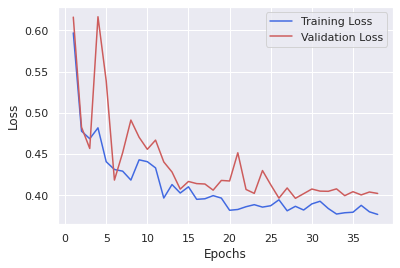

In [ ]:
### Loss

epochs = range(1, len(history.history['loss'])+1)       # Número de épocas
training_loss = history.history['loss']                 # Lista com a evolução da loss (treino)
validation_loss = history.history['val_loss']           # Lista com a evolução da loss (validation)

# Plot
plt.plot(epochs, training_loss,     # Dados de treino
         color='royalblue',         # Cor
         label='Training Loss')     # Label (para a legenda)

plt.plot(epochs, validation_loss,   # Dados de validação
         color='indianred',         # Cor
         label='Validation Loss')   # Label

plt.xlabel('Epochs')        # Nome do eixo X
plt.ylabel('Loss')          # Nome do eixo Y
plt.legend()

plt.show()

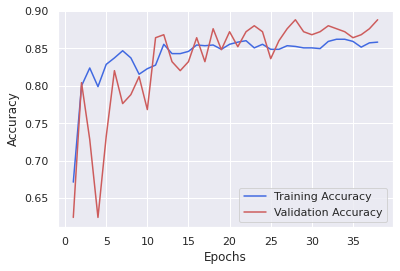

In [ ]:
### Accuracy

epochs = range(1, len(history.history['loss'])+1)
training_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

plt.plot(epochs, training_acc,
         color='royalblue',
         label='Training Accuracy')
plt.plot(epochs, validation_acc,
         color='indianred',
         label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

> A célula abaixo restaura os pesos salvos da melhor época do treinamento.

In [ ]:
#model.load_weights('/content/content/model.h5')

## Avaliação no Conjunto de Testes

In [ ]:
# Cria um gerador que retorna, de uma só vez, todas as imagens de teste
todas_imagens = datagen_teste.flow_from_directory(
            test_path,
            target_size=(TAMANHO_IMAGEM,TAMANHO_IMAGEM),
            batch_size=456,               
            class_mode='categorical',   
            shuffle=False)   

Found 455 images belonging to 2 classes.


### Avaliação do modelo (pelo Keras)

In [ ]:
# Avaliação feita pelo próprio Keras
stats = model.evaluate(todas_imagens)

1/1 [==============================] - 6s 6s/step - loss: 0.4120 - accuracy: 0.8725 - auc_2: 0.8992 - recall_2: 0.8725


In [ ]:
# Métricas geradas pelo keras
print("Loss:", stats[0])
print("Accuracy:", stats[1])
print("ROC AUC:", stats[2])
print("Recall:", stats[3])

Loss: 0.41197308897972107
Accuracy: 0.8725274801254272
ROC AUC: 0.899234414100647
Recall: 0.8725274801254272


### Realizando predições

In [ ]:
imagens_batch = todas_imagens.next()    # Carrega as imagens
y_teste = imagens_batch[1]              # Separa os labels
imagens_teste = imagens_batch[0]        # Armazena só as imagens

In [ ]:
y_teste.shape

(455, 2)

In [ ]:
imagens_teste.shape

(455, 96, 96, 3)

In [ ]:
# Criando um vetor com o resultado da predição
predictions = model.predict(imagens_teste)
predictions.shape

(455, 2)

In [ ]:
### Transforma a classificação. Como há 2 neurônios na saída, cada predição é uma lista com 2 valores.
    # essa célula transforma esse array em um formato (455, 1)
def pred_refactor(arr):
    if arr[0] > arr[1]:
        return 0
    else:
        return 1

predictions = np.apply_along_axis(pred_refactor, 1, predictions)
y_teste = np.apply_along_axis(pred_refactor, 1, y_teste)

### Métricas (SKLearn)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score

In [ ]:
# Acc
print("Acurácia:", accuracy_score(y_teste, predictions))

Acurácia: 0.8725274725274725


In [ ]:
# ROC AUC
print("ROC AUC:", roc_auc_score(y_teste, predictions))

ROC AUC: 0.8436147186147185


In [ ]:
# Recall, precision e F1
print("Recall:", recall_score(y_teste, predictions))
print("Precision:", precision_score(y_teste, predictions))
print("F1 Score: ", f1_score(y_teste, predictions))

Recall: 0.9253246753246753
Precision: 0.890625
F1 Score:  0.9076433121019108


### Matriz de Confusão

In [ ]:
# Matriz de confusão
confusion_matrix(y_teste, predictions)

array([[112,  35],
       [ 23, 285]])

In [ ]:
# Labels
print(todas_imagens.class_indices)

{'a_benigno': 0, 'b_maligno': 1}


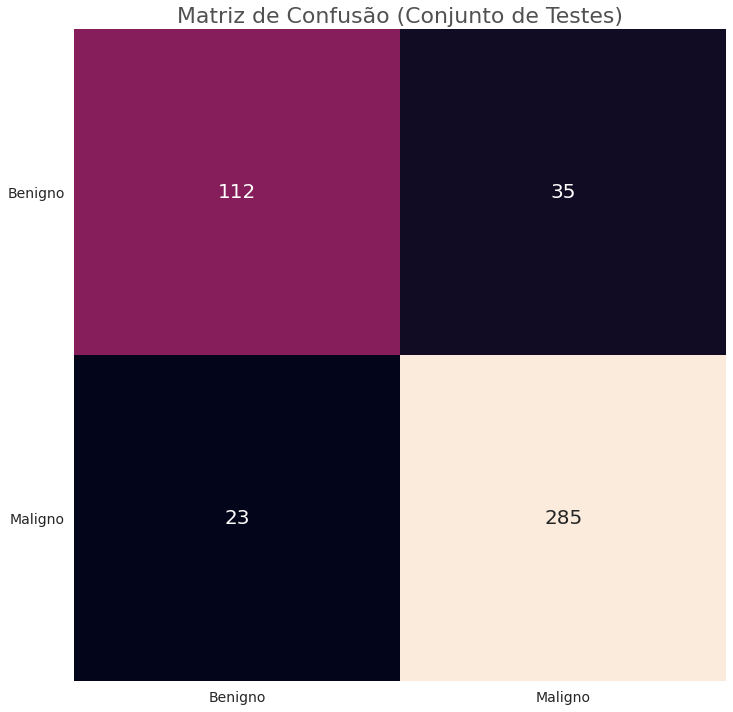

In [ ]:
# Criando um DataFrame. O índice e as colunas são os nomes dos batimentos, os valores são os retornados pela matriz de confusão
df_cm = pd.DataFrame(confusion_matrix(y_teste, predictions), index = ["Benigno", "Maligno"],
                  columns = ["Benigno", "Maligno"])

# Criando uma figura 12x12
plt.figure(figsize = (12,12))

# Criando um heatmap com base no dataframe criado anteriormente
ax = sns.heatmap(df_cm,
                 annot=True,  # ativa a anotação dos valores dentro dos quadrados
                 fmt='g',   # retira a notação científica dos valores
                 cbar=False,  # retira o cbar da imagem
                 square=True, # plot em forma de quadrados
                 annot_kws={"fontsize":20}) # define o tamanho da fonte dos números

# Define tamanho da fonte dos labels dos eixos x e y
plt.yticks(fontsize=14, rotation=0)
plt.xticks(fontsize=14)

# Adiciona um título
plt.title("Matriz de Confusão (Conjunto de Testes)", size=22, alpha=0.8)

plt.show();

## Salvando o modelo

In [ ]:
model.save('/model')

INFO:tensorflow:Assets written to: /model/assets


In [ ]:
!zip -r /content/model-24052021.zip /model

  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 88%)
  adding: model/assets/ (stored 0%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.index (deflated 64%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 16%)
